In [1]:
import mlflow.pyfunc
import mlflow
from mlflow.models import ModelSignature
from mlflow.types.schema import Schema, ColSpec, ParamSchema
from PIL import Image
import numpy as np
from io import BytesIO
import io
import base64
import requests

In [2]:
def pil_img_to_b64(input_image):
    buffer = BytesIO()
    input_image.save(buffer, format="JPEG")
    B64ResponseImage = base64.b64encode(buffer.getvalue())
    string_b64_file = str(B64ResponseImage, encoding='utf-8')

    return string_b64_file

def b64_to_pil_img(b64_string):
    b64_img = str.encode(b64_string)
    decoded_b64_img =  base64.b64decode(b64_img)
    output_img = Image.open(io.BytesIO(decoded_b64_img))

    return output_img

In [3]:
class BWModel(mlflow.pyfunc.PythonModel):
    def predict(self, context, model_input, params):
        img = b64_to_pil_img(model_input["dog_image"][0])
        img = img.convert('L')
        return pil_img_to_b64(img)

In [16]:
# Save the model
input_schema = Schema(
    [
        ColSpec("string", "dog_image")
    ]
)

output_schema = Schema(
    [
        ColSpec("string", "dog_image")
    ]
)

signature = ModelSignature(inputs=input_schema, outputs=output_schema)

mlflow.set_experiment("BWModel")
with mlflow.start_run() as run:
    model_info = mlflow.pyfunc.log_model(
        python_model=BWModel(),
        artifact_path="BWModel",
        signature=signature,
        registered_model_name="BWModel" ##Register the model
    )

client = mlflow.MlflowClient()
model_metadata = client.get_latest_versions("BWModel", stages=["None"])
latest_model_version = model_metadata[0].version

Registered model 'BWModel' already exists. Creating a new version of this model...
2024/01/26 16:27:40 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation. Model name: BWModel, version 3
Created version '3' of model 'BWModel'.


In [20]:
mlflow.models.get_model_info(f"models:/BWModel/{latest_model_version}").signature

inputs: 
  ['dog_image': string]
outputs: 
  ['dog_image': string]
params: 
  None

# Usage

In the following are two ways to use the registered models. 

## Loading the model

Using pyfunc.load_model you can test if your model is working well, but it doesn`t involves nothing of the model services feature.

In order to use it, change the version of model_uri to the latests version you deployed

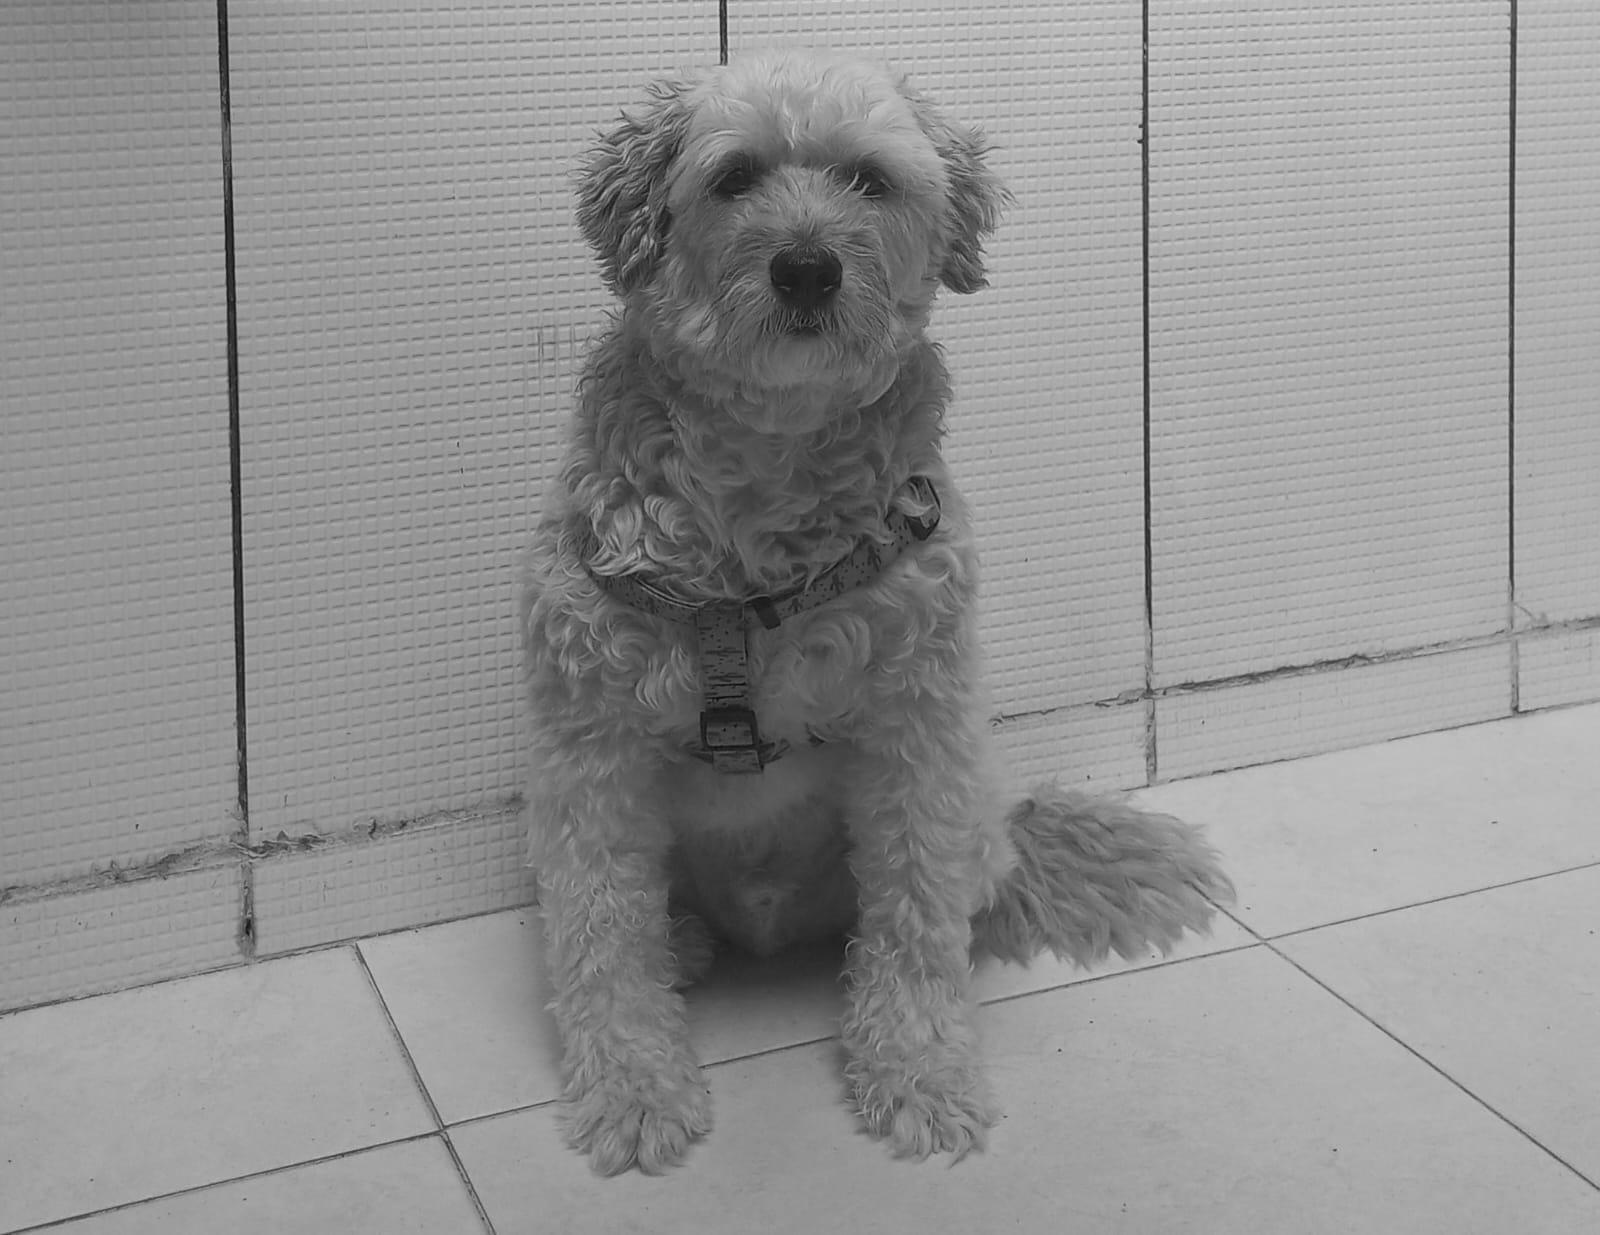

In [18]:
img = Image.open("Luke.jpeg")
model = mlflow.pyfunc.load_model(model_uri=f"models:/BWModel/{latest_model_version}")
resp = model.predict({"dog_image":pil_img_to_b64(img)})
b64_to_pil_img(resp)

## Model services

Go to the published services page and create a model, run it and wait until the running state. Change the URL field below to the url of the published services.

/opt/conda/lib/python3.11/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.137.137.85'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


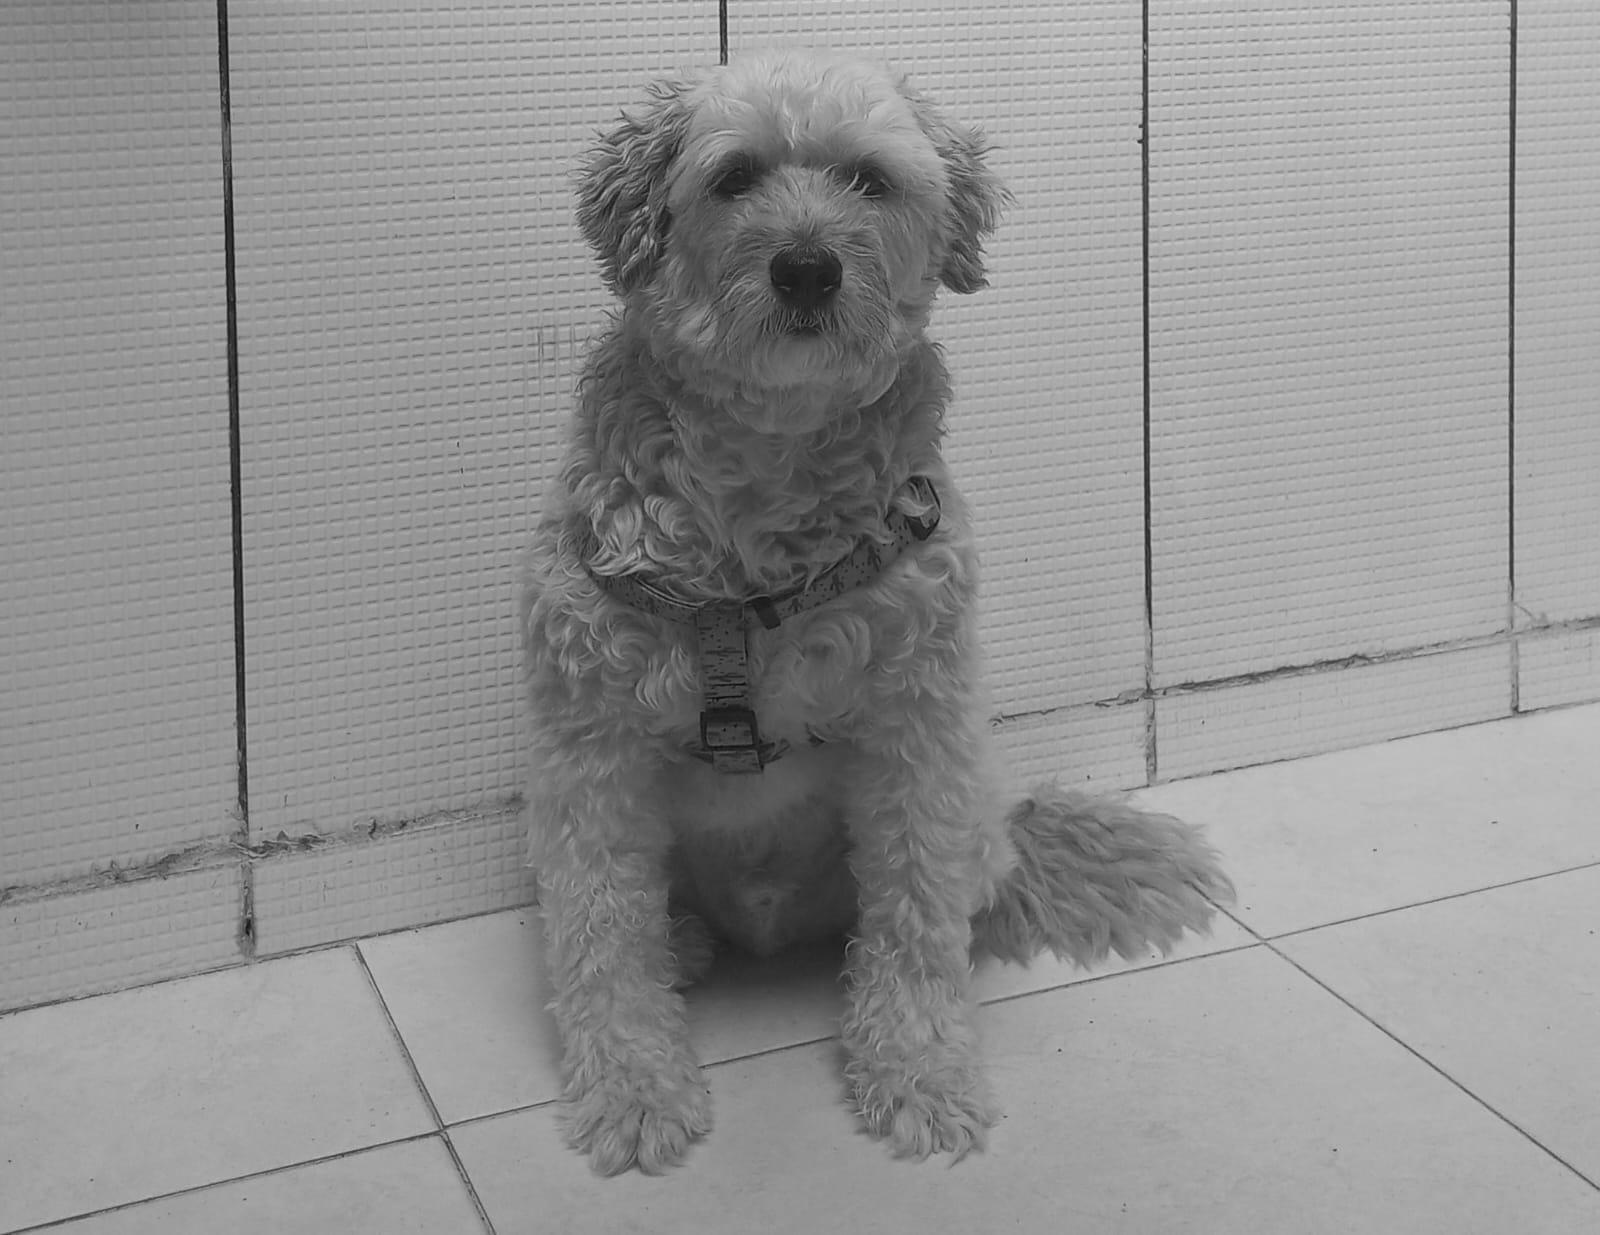

In [5]:
# Model service 🤘
imgBase64 =  Image.open("Luke.jpeg")

url = "https://10.137.137.85:5000"+"/invocations"
data = {
    "inputs":{
        "dog_image":[pil_img_to_b64(imgBase64)],
    }
}

headers = {'Content-type': 'application/json'}
response = requests.post(url, json = data, verify=False, headers=headers)

b64_to_pil_img(response.json()["predictions"])